In [182]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from imports import *
from helpers import *
import matplotlib.pyplot as plt
# Loading the datasets to memory
TRAINING_DIR = f'{DATA_DIR}2019_07_03_TRAINING/'
for f in os.listdir(TRAINING_DIR):
    ds_name = f.split('.')[0]
    if not ds_name in globals():
        exec(f'{ds_name} = pd.read_parquet("{TRAINING_DIR}{f}")')
    print(ds_name, end=', ')
print('\nloaded')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ystrong, Xall, Xtest_weak, Ytest, Xstrong, Yall, Xtest, Ytest_weak, 
loaded


# create a model

In [66]:
from keras.layers import Input, Dense, BatchNormalization, Dropout, Add
from keras.models import Model
from keras_lamb import LAMBOptimizer
from clr import LRFinder, OneCycleLR
from keras.callbacks import EarlyStopping, ModelCheckpoint

INP_SIZE = Xall.shape[1]
OUT_SIZE = Yall.shape[1]
LAYERS_SIZE = [1000, 700, 500]

def dense_norm_layer(x, size, bn=True, drop=0.3):
    x = Dense(size, kernel_initializer='he_normal', activation='relu')(x)
    if bn: x = BatchNormalization()(x)
    if drop > 0: x = Dropout(drop)(x)    
    return x 

def layers_series(x, sizes, bn=True, drop=0.3):
    for size in sizes:
        x = dense_norm_layer(x, size, bn, drop)
    return x

def Gene_trait_model(inp_size = INP_SIZE, 
                     layers_size = LAYERS_SIZE, 
                     out_size=OUT_SIZE,
                     skip_branch = True):
    
    '''generate a keras model for trainign gene to trait map'''
    inp = x = Input(shape=(inp_size,))
    x = layers_series(x, layers_size)
    if skip_branch: x = Add()([x, dense_norm_layer(inp, layers_size[-1])])
    out = dense_norm_layer(x, out_size, False, 0)
    model = Model(inp, out)
    model.compile(loss='mse', optimizer=LAMBOptimizer())
    return model
        
if not 'model' in globals():  
    model = Gene_trait_model()  
    x,y = Xall.values, Yall.values
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 3153)         0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 1000)         3154000     input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 1000)         4000        dense_41[0][0]                   
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 1000)         0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
dense_42 (

# find learning rate

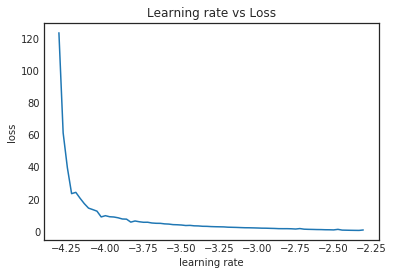

In [41]:
num_samples = len(Xall)
batch_size = 1024
minimum_lr, maximum_lr = 0.00005, 0.005
if not os.path.isdir('modeling'): os.mkdir('modeling')
lr_callback = LRFinder(num_samples, batch_size, minimum_lr, maximum_lr,
                       lr_scale='exp', save_dir='modeling')

model = Gene_trait_model()
model.fit(x, y, epochs=1, batch_size=batch_size, callbacks=[lr_callback])
clear_output()
lr_callback.plot_schedule()

In [59]:
batch_size = 1024
max_lr = 0.002

num_samples = len(x)

lr_manager = OneCycleLR(max_lr, end_percentage=0.1, verbose=False)

In [67]:
from datetime import datetime
now = datetime.now()

fname = f"modeling/{now.strftime('%Y_%m_%d')}_model_weights_gene_to_trait.h5"
if os.path.isfile(fname):
    modl.load_weights(fname)
num_epoch = 1000  
cb = [
      EarlyStopping(patience=100, monitor='loss'),
      ModelCheckpoint(fname, monitor='loss',save_best_only=True, save_weights_only=True)
     ]

model.fit(x,y,epochs=num_epoch, batch_size=batch_size, callbacks=cb, validation_split=0.1)

Train on 66598 samples, validate on 7400 samples
Epoch 1/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1347 - val_loss: 0.1220
Epoch 2/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1343 - val_loss: 0.1215
Epoch 3/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1344 - val_loss: 0.1216
Epoch 4/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1339 - val_loss: 0.1213
Epoch 5/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1340 - val_loss: 0.1210
Epoch 6/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1337 - val_loss: 0.1210
Epoch 7/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1333 - val_loss: 0.1209
Epoch 8/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1337 - val_loss: 0.1207
Epoch 9/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.133

Epoch 76/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1247 - val_loss: 0.1146
Epoch 77/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1252 - val_loss: 0.1146
Epoch 78/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1248 - val_loss: 0.1146
Epoch 79/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1248 - val_loss: 0.1145
Epoch 80/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1246 - val_loss: 0.1146
Epoch 81/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1247 - val_loss: 0.1145
Epoch 82/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1245 - val_loss: 0.1145
Epoch 83/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1245 - val_loss: 0.1144
Epoch 84/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1246 - val_loss: 0.1144
Epoch 85/1000
66598

66598/66598 [==============================] - 7s 112us/step - loss: 0.1213 - val_loss: 0.1131
Epoch 225/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1216 - val_loss: 0.1132
Epoch 226/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1214 - val_loss: 0.1132
Epoch 227/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1214 - val_loss: 0.1132
Epoch 228/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1214 - val_loss: 0.1132
Epoch 229/1000
66598/66598 [==============================] - 8s 113us/step - loss: 0.1215 - val_loss: 0.1131
Epoch 230/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1213 - val_loss: 0.1131
Epoch 231/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1212 - val_loss: 0.1132
Epoch 232/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1215 - val_loss: 0.1132
Epoch 233/1000
66598/6659

66598/66598 [==============================] - 7s 112us/step - loss: 0.1204 - val_loss: 0.1129
Epoch 373/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1204 - val_loss: 0.1129
Epoch 374/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1203 - val_loss: 0.1128
Epoch 375/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1204 - val_loss: 0.1129
Epoch 376/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1204 - val_loss: 0.1129
Epoch 377/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1204 - val_loss: 0.1129
Epoch 378/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1203 - val_loss: 0.1129
Epoch 379/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1205 - val_loss: 0.1129
Epoch 380/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1203 - val_loss: 0.1129
Epoch 381/1000
66598/6659

66598/66598 [==============================] - 7s 112us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 521/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1197 - val_loss: 0.1129
Epoch 522/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 523/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 524/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 525/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 526/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 527/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 528/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.1197 - val_loss: 0.1128
Epoch 529/1000
66598/6659

66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 669/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 670/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 671/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 672/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 673/1000
66598/66598 [==============================] - 7s 111us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 674/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 675/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 676/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0831 - val_loss: 0.0868
Epoch 677/1000
66598/6659

66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 817/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 818/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 819/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 820/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 821/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 822/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 823/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 824/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 825/1000
66598/6659

66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 965/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 966/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 967/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 968/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 969/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 970/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 971/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 972/1000
66598/66598 [==============================] - 7s 112us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 973/1000
66598/6659

In [70]:
fname = f"modeling/{now.strftime('%Y_%m_%d')}_model_weights_gene_to_trait_2.h5"
batch_size = 512
num_epoch = 10000 
cb = [
      EarlyStopping(patience=200, monitor='loss'),
      ModelCheckpoint(fname, monitor='loss',save_best_only=True, save_weights_only=True)
     ]

model.fit(x,y,epochs=num_epoch, batch_size=batch_size, callbacks=cb, validation_split=0.1)

Train on 66598 samples, validate on 7400 samples
Epoch 1/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 2/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 3/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 4/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 5/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 6/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 7/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 8/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 9/10000
66598/66598 [==============================] - 9s 135us/step - lo

66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 79/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 80/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 81/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 82/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 83/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 84/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 85/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 86/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 87/10000
66598/6659

66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 153/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 154/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 155/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 156/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 157/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 158/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 159/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 160/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 161/10000
6

Epoch 226/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 227/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 228/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 229/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 230/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 231/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 232/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 233/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 234/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 300/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 301/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 302/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 303/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 304/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 305/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 306/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 307/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 308/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 374/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 375/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 376/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 377/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 378/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 379/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 380/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 381/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 382/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 448/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 449/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 450/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 451/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 452/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 453/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 454/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 455/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 456/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 522/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 523/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 524/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 525/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 526/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 527/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 528/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 529/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 530/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
E

Epoch 596/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 597/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 598/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 599/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 600/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 601/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 602/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 603/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 604/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
E

Epoch 670/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 671/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 672/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 673/10000
66598/66598 [==============================] - 9s 134us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 674/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 675/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 676/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 677/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 678/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 744/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 745/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 746/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 747/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 748/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 749/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 750/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 751/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 752/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 818/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 819/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 820/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 821/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 822/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 823/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 824/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 825/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 826/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 892/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 893/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 894/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 895/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 896/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 897/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 898/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 899/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 900/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

Epoch 966/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 967/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 968/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 969/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0868
Epoch 970/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 971/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 972/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 973/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
Epoch 974/10000
66598/66598 [==============================] - 9s 135us/step - loss: 0.0830 - val_loss: 0.0869
E

In [71]:
# train on all data:
fname = f"modeling/{now.strftime('%Y_%m_%d')}_model_weights_gene_to_trait_2.h5"
batch_size = 512
num_epoch = 10000 
cb = [
      EarlyStopping(patience=100, monitor='loss'),
      ModelCheckpoint(fname, monitor='loss',save_best_only=True, save_weights_only=True)
     ]

model.fit(x,y,epochs=num_epoch, batch_size=batch_size, callbacks=cb)

Epoch 1/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0834
Epoch 2/10000
73998/73998 [==============================] - 10s 131us/step - loss: 0.0833
Epoch 3/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 4/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 5/10000
73998/73998 [==============================] - 10s 131us/step - loss: 0.0833
Epoch 6/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 7/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 8/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 9/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 10/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 11/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.08

73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 91/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 92/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 93/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 94/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 95/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 96/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 97/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 98/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 99/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 100/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Ep

73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 267/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 268/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 269/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 270/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 271/10000
73998/73998 [==============================] - 10s 133us/step - loss: 0.0833
Epoch 272/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 273/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 274/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 275/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 276/10000
73998/73998 [==============================] - 10s 132us/step - loss: 

73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 443/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 444/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 445/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 446/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 447/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 448/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 449/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 450/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 451/10000
73998/73998 [==============================] - 10s 132us/step - loss: 0.0833
Epoch 452/10000
73998/73998 [==============================] - 10s 132us/step - loss: 

# evaluate in terms of traits

In [110]:
def prep_test_data(Xtest, Ytest):
    test_data = pd.DataFrame({'Entry' : Xtest.index, 'TO' : Ytest.index})
    test_data = (test_data
                 .drop_duplicates()
                 .groupby('Entry')
                 .agg(tuple))

    Xtest['Entry'] = Xtest.index
    test_data['Entry'] = test_data.index
    test_data = pd.merge(test_data, Xtest, how='left', on='Entry').drop_duplicates()
    return test_data

test_data = prep_test_data(Xtest, Ytest)
test_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 'Entry' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


TO       Entry  \
0                              (abiotic stress trait,)  A0A0P0UZ65   
1                              (abiotic stress trait,)  A0A0P0VSF3   
2                              (abiotic stress trait,)  A0A0P0VVT8   
3                              (abiotic stress trait,)  A0A0P0W3U8   
4                              (abiotic stress trait,)  A0A0P0WKZ0   
8                              (abiotic stress trait,)  A0A0P0WSK0   
9                              (abiotic stress trait,)  A0A3Q7EKL1   
10                             (abiotic stress trait,)  A0A3Q7FGD5   
11                             (abiotic stress trait,)  A0A3Q7HQW9   
12                        (abscisic acid sensitivity,)  A0A3Q7HU42   
13   (abscisic acid sensitivity, bacterial blight d...      A3C039   
15              (bacterial blight disease resistance,)      B3IYE3   
16                     (bacterial disease resistance,)      O04196   
17                     (bacterial disease resistance,)      O04609   
19                     (bacterial disease resistance,)      O23553   
21                     (bacterial disease resistance,)      P23419   
22   (bacterial disease resistance, biochemical trait)      P43254   
25   (blue light sensitivity, cardinal organ part m...      Q0DJ33   
29   (cardinal part of a multi-tissue plant structu...      Q10MN2   
31             (cell cycle trait, chlorophyll content)      Q2LAE1   
35                              (chlorophyll content,)      Q2QM96   
37               (chlorophyll content, cold tolerance)      Q2QW53   
39              (cold tolerance, copper concentration)      Q39023   
41   (copper concentration, copper content trait, d...      Q5JK06   
45             (disease resistance, drought tolerance)      Q5K4R0   
57   (enzyme activity trait, far red light sensitiv...      Q5N800   
61    (flower development trait, flowering time trait)      Q5N870   
65                             (flowering time trait,)      Q652K1   
69                             (flowering time trait,)      Q6EN34   
71               (fruit growth and development trait,)      Q6EN42   
..                                                 ...         ...   
109                        (metabolite content trait,)      Q7Y0Y8   
111                        (metabolite content trait,)      Q84T96   
113                   (mineral and ion content trait,)      Q8GW31   
115           (mitotic cell cycle trait, plant height)      Q8H1F2   
118                                    (plant height,)      Q8L3W1   
120                                    (plant height,)      Q8L5Y6   
125                          (plant morphology trait,)      Q8L7R2   
127                (plant structure morphology trait,)      Q8LPK5   
128                (plant structure morphology trait,)      Q8LPK8   
129  (plant tissue development trait, protist disea...      Q8RXG3   
131  (protist disease resistance, reproductive home...      Q8VYR7   
133                          (root development trait,)      Q93Y07   
134                          (root development trait,)      Q94C37   
135           (root development trait, salt tolerance)      Q9C5Q8   
137                                  (salt tolerance,)      Q9C5V6   
138                                  (salt tolerance,)      Q9C5W7   
140                            (senesced leaf number,)      Q9C7S0   
142               (shoot apical meristem development,)      Q9FF86   
144  (shoot apical meristem development, stem morph...      Q9FL28   
146                    (sterility or fertility trait,)      Q9FU27   
147                    (sterility or fertility trait,)      Q9FX31   
148                    (sterility or fertility trait,)      Q9LGE3   
150                    (sterility or fertility trait,)      Q9LSQ2   
152                       (trichome morphology trait,)      Q9LTB0   
154                       (trichome morphology trait,)      Q9SEE9   
155                       (trichome morphology trait,)      Q9

In [159]:
from sklearn.neighbors import NearestNeighbors
emb_map = pd.read_parquet(TRAIT_ONTOLOGY_BERT_EMBEDDING_FILE)

def embedding_to_traits(embedding, n_neigh = 5, emb_map=emb_map, show_dist=True):
    nn = NearestNeighbors(n_neighbors=n_neigh, metric='cosine').fit(emb_map.values)
    distances, idxs = nn.kneighbors(embedding)
    ontologies = emb_map.index.values[idxs]
    if not show_dist: return ontologies
    return [list(zip(on, distances[i])) for i, on in enumerate(ontologies)]

X = test_data.values[:, 2:]
pred = model.predict(X)
predicted_traits = embedding_to_traits(pred, n_neigh=10, show_dist=False)
evaluation = test_data[['Entry', 'TO']].copy()
evaluation['pred'] = [tuple(v) for v in predicted_traits]
evaluation['intersection'] = [len(set(to).intersection(set(pred))) for to, pred in evaluation[['TO', 'pred']].values]
accuracy = evaluation['intersection'].sum() / evaluation['intersection'].count()
print(accuracy)
evaluation

0.07352941176470588


Entry                                                 TO  \
0    A0A0P0UZ65                            (abiotic stress trait,)   
1    A0A0P0VSF3                            (abiotic stress trait,)   
2    A0A0P0VVT8                            (abiotic stress trait,)   
3    A0A0P0W3U8                            (abiotic stress trait,)   
4    A0A0P0WKZ0                            (abiotic stress trait,)   
8    A0A0P0WSK0                            (abiotic stress trait,)   
9    A0A3Q7EKL1                            (abiotic stress trait,)   
10   A0A3Q7FGD5                            (abiotic stress trait,)   
11   A0A3Q7HQW9                            (abiotic stress trait,)   
12   A0A3Q7HU42                       (abscisic acid sensitivity,)   
13       A3C039  (abscisic acid sensitivity, bacterial blight d...   
15       B3IYE3             (bacterial blight disease resistance,)   
16       O04196                    (bacterial disease resistance,)   
17       O04609                    (bacterial disease resistance,)   
19       O23553                    (bacterial disease resistance,)   
21       P23419                    (bacterial disease resistance,)   
22       P43254  (bacterial disease resistance, biochemical trait)   
25       Q0DJ33  (blue light sensitivity, cardinal organ part m...   
29       Q10MN2  (cardinal part of a multi-tissue plant structu...   
31       Q2LAE1            (cell cycle trait, chlorophyll content)   
35       Q2QM96                             (chlorophyll content,)   
37       Q2QW53              (chlorophyll content, cold tolerance)   
39       Q39023             (cold tolerance, copper concentration)   
41       Q5JK06  (copper concentration, copper content trait, d...   
45       Q5K4R0            (disease resistance, drought tolerance)   
57       Q5N800  (enzyme activity trait, far red light sensitiv...   
61       Q5N870   (flower development trait, flowering time trait)   
65       Q652K1                            (flowering time trait,)   
69       Q6EN34                            (flowering time trait,)   
71       Q6EN42              (fruit growth and development trait,)   
..          ...                                                ...   
109      Q7Y0Y8                        (metabolite content trait,)   
111      Q84T96                        (metabolite content trait,)   
113      Q8GW31                   (mineral and ion content trait,)   
115      Q8H1F2           (mitotic cell cycle trait, plant height)   
118      Q8L3W1                                    (plant height,)   
120      Q8L5Y6                                    (plant height,)   
125      Q8L7R2                          (plant morphology trait,)   
127      Q8LPK5                (plant structure morphology trait,)   
128      Q8LPK8                (plant structure morphology trait,)   
129      Q8RXG3  (plant tissue development trait, protist disea...   
131      Q8VYR7  (protist disease resistance, reproductive home...   
133      Q93Y07                          (root development trait,)   
134      Q94C37                          (root development trait,)   
135      Q9C5Q8           (root development trait, salt tolerance)   
137      Q9C5V6                                  (salt tolerance,)   
138      Q9C5W7                                  (salt tolerance,)   
140      Q9C7S0                            (senesced leaf number,)   
142      Q9FF86               (shoot apical meristem development,)   
144      Q9FL28  (shoot apical meristem development, stem morph...   
146      Q9FU27                    (sterility or fertility trait,)   
147      Q9FX31                    (sterility or fertility trait,)   
148      Q9LGE3                    (sterility or fertility trait,)   
150      Q9LSQ2                    (sterility or fertility trait,)   
152      Q9LTB0                       (trichome morphology trait,)   
154      Q9SEE9                       (trichome morphology trait,)   
155      Q9SUT5     

# Reduce the possible traits only to the traits that were used in the training

In [171]:
if not 'available_traits' in globals():
    training_data = merge_and_prepare_training_data()
    available_traits = training_data['TO'].unique()
    emb_map = pd.read_parquet(TRAIT_ONTOLOGY_BERT_EMBEDDING_FILE)

emb_map = emb_map.loc[available_traits]
emb_map.shape

(259, 768)

In [175]:
from sklearn.neighbors import NearestNeighbors

def embedding_to_traits(embedding, n_neigh = 10, emb_map=emb_map, show_dist=True):
    nn = NearestNeighbors(n_neighbors=n_neigh, metric='cosine').fit(emb_map.values)
    distances, idxs = nn.kneighbors(embedding)
    ontologies = emb_map.index.values[idxs]
    if not show_dist: return ontologies
    return [list(zip(on, distances[i])) for i, on in enumerate(ontologies)]

X = test_data.values[:, 2:]
pred = model.predict(X)
predicted_traits = embedding_to_traits(pred, n_neigh=20, show_dist=False)
evaluation = test_data[['Entry', 'TO']].copy()
evaluation['pred'] = [tuple(v) for v in predicted_traits]
evaluation['intersection'] = [len(set(to).intersection(set(pred))) for to, pred in evaluation[['TO', 'pred']].values]
accuracy = evaluation['intersection'].sum() / evaluation['intersection'].count()
print(accuracy)
evaluation

0.17647058823529413


Entry                                                 TO  \
0    A0A0P0UZ65                            (abiotic stress trait,)   
1    A0A0P0VSF3                            (abiotic stress trait,)   
2    A0A0P0VVT8                            (abiotic stress trait,)   
3    A0A0P0W3U8                            (abiotic stress trait,)   
4    A0A0P0WKZ0                            (abiotic stress trait,)   
8    A0A0P0WSK0                            (abiotic stress trait,)   
9    A0A3Q7EKL1                            (abiotic stress trait,)   
10   A0A3Q7FGD5                            (abiotic stress trait,)   
11   A0A3Q7HQW9                            (abiotic stress trait,)   
12   A0A3Q7HU42                       (abscisic acid sensitivity,)   
13       A3C039  (abscisic acid sensitivity, bacterial blight d...   
15       B3IYE3             (bacterial blight disease resistance,)   
16       O04196                    (bacterial disease resistance,)   
17       O04609                    (bacterial disease resistance,)   
19       O23553                    (bacterial disease resistance,)   
21       P23419                    (bacterial disease resistance,)   
22       P43254  (bacterial disease resistance, biochemical trait)   
25       Q0DJ33  (blue light sensitivity, cardinal organ part m...   
29       Q10MN2  (cardinal part of a multi-tissue plant structu...   
31       Q2LAE1            (cell cycle trait, chlorophyll content)   
35       Q2QM96                             (chlorophyll content,)   
37       Q2QW53              (chlorophyll content, cold tolerance)   
39       Q39023             (cold tolerance, copper concentration)   
41       Q5JK06  (copper concentration, copper content trait, d...   
45       Q5K4R0            (disease resistance, drought tolerance)   
57       Q5N800  (enzyme activity trait, far red light sensitiv...   
61       Q5N870   (flower development trait, flowering time trait)   
65       Q652K1                            (flowering time trait,)   
69       Q6EN34                            (flowering time trait,)   
71       Q6EN42              (fruit growth and development trait,)   
..          ...                                                ...   
109      Q7Y0Y8                        (metabolite content trait,)   
111      Q84T96                        (metabolite content trait,)   
113      Q8GW31                   (mineral and ion content trait,)   
115      Q8H1F2           (mitotic cell cycle trait, plant height)   
118      Q8L3W1                                    (plant height,)   
120      Q8L5Y6                                    (plant height,)   
125      Q8L7R2                          (plant morphology trait,)   
127      Q8LPK5                (plant structure morphology trait,)   
128      Q8LPK8                (plant structure morphology trait,)   
129      Q8RXG3  (plant tissue development trait, protist disea...   
131      Q8VYR7  (protist disease resistance, reproductive home...   
133      Q93Y07                          (root development trait,)   
134      Q94C37                          (root development trait,)   
135      Q9C5Q8           (root development trait, salt tolerance)   
137      Q9C5V6                                  (salt tolerance,)   
138      Q9C5W7                                  (salt tolerance,)   
140      Q9C7S0                            (senesced leaf number,)   
142      Q9FF86               (shoot apical meristem development,)   
144      Q9FL28  (shoot apical meristem development, stem morph...   
146      Q9FU27                    (sterility or fertility trait,)   
147      Q9FX31                    (sterility or fertility trait,)   
148      Q9LGE3                    (sterility or fertility trait,)   
150      Q9LSQ2                    (sterility or fertility trait,)   
152      Q9LTB0                       (trichome morphology trait,)   
154      Q9SEE9                       (trichome morphology trait,)   
155      Q9SUT5     

In [178]:
weak_test_data = prep_test_data(Xtest_weak, Ytest_weak)
X = weak_test_data.values[:, 2:]
pred = model.predict(X)
print(pred)
predicted_traits = embedding_to_traits(pred, n_neigh=20, show_dist=False)
evaluation = weak_test_data[['Entry', 'TO']].copy()
evaluation['pred'] = [tuple(v) for v in predicted_traits]
evaluation['intersection'] = [len(set(to).intersection(set(pred))) for to, pred in evaluation[['TO', 'pred']].values]
accuracy = evaluation['intersection'].sum() / evaluation['intersection'].count()
print(accuracy)
evaluation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'Entry' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


[[0.50791824 0.08141316 0.         ... 0.11218271 0.23233028 0.21195257]
 [0.48430932 0.07468838 0.         ... 0.13412324 0.30376142 0.21311054]
 [0.50791824 0.08141316 0.         ... 0.11218271 0.23233028 0.21195257]
 ...
 [0.48430932 0.07468838 0.         ... 0.13412324 0.30376142 0.21311054]
 [0.50791824 0.08141316 0.         ... 0.11218271 0.23233028 0.21195257]
 [0.79410803 0.         0.03748102 ... 0.05378953 0.         0.3457368 ]]
0.06330365974282888


Entry                                        TO  \
0      A0A060CVM9                   (abiotic stress trait,)   
2      A0A060D3B5                   (abiotic stress trait,)   
7      A0A060D609                   (abiotic stress trait,)   
14     A0A077RXD0                   (abiotic stress trait,)   
15     A0A096QGQ9                   (abiotic stress trait,)   
16     A0A096QUG1                   (abiotic stress trait,)   
18     A0A096QXB7                   (abiotic stress trait,)   
20     A0A096R6U6                   (abiotic stress trait,)   
23     A0A096RL31                   (abiotic stress trait,)   
28     A0A096S3Z9                   (abiotic stress trait,)   
32     A0A096SFC8                   (abiotic stress trait,)   
36     A0A096UDW3                   (abiotic stress trait,)   
47     A0A0A0K193                   (abiotic stress trait,)   
49     A0A0A0K266                   (abiotic stress trait,)   
50     A0A0A0K5X0                   (abiotic stress trait,)   
51     A0A0A0K6K8                   (abiotic stress trait,)   
53     A0A0A0K700                   (abiotic stress trait,)   
54     A0A0A0K8P7                   (abiotic stress trait,)   
55     A0A0A0KBA1                   (abiotic stress trait,)   
56     A0A0A0KBG5                   (abiotic stress trait,)   
59     A0A0A0KBM0                   (abiotic stress trait,)   
60     A0A0A0KD17                   (abiotic stress trait,)   
62     A0A0A0KEW2                   (abiotic stress trait,)   
63     A0A0A0KFU2                   (abiotic stress trait,)   
66     A0A0A0KGE5                   (abiotic stress trait,)   
67     A0A0A0KGL4                   (abiotic stress trait,)   
68     A0A0A0KGP9                   (abiotic stress trait,)   
69     A0A0A0KIE1                   (abiotic stress trait,)   
70     A0A0A0KIL6                   (abiotic stress trait,)   
72     A0A0A0KJJ6                   (abiotic stress trait,)   
...           ...                                       ...   
12522      Q9FVZ7                            (yield trait,)   
12524      Q9FWU1                            (yield trait,)   
12536      Q9FWU4                            (yield trait,)   
12548      Q9FWV1                            (yield trait,)   
12560      Q9FWV7                            (yield trait,)   
12572      Q9FYP9                            (yield trait,)   
12596      Q9LG41                            (yield trait,)   
12608      Q9LGU7                            (yield trait,)   
12648      Q9LQU2                            (yield trait,)   
12649      Q9LRR7                            (yield trait,)   
12651      Q9LW29                            (yield trait,)   
12656      Q9LWM4                            (yield trait,)   
12684      Q9M7Q3                            (yield trait,)   
12686      Q9M7Q4                            (yield trait,)   
12688      Q9S836                            (yield trait,)   
12690      Q9SDG6                            (yield trait,)   
12700      Q9SKD9                            (yield trait,)   
12701      Q9SLG0                            (yield trait,)   
12704      Q9SNL3                            (yield trait,)   
12714      Q9SSW1                            (yield trait,)   
12715      Q9SSY2                            (yield trait,)   
12718      Q9SX38                            (yield trait,)   
12720      Q9XHL5                            (yield trait,)   
12730      Q9XHX0                     (zeaxanthin content,)   
12738      Q9ZNY1  (zeaxanthin content, zinc concentration)   
12743      Q9ZR12                     (zinc concentration,)   
12748      R4WUP9                     (zinc concentration,)   
12750      R4X4I5  (zinc concentration, zinc content trait)   
12752      W5U5X2                     (zinc content trait,)   
12758      W6JQR4                     (zinc content trait,)   

                                                    pred  intersection  
0      (floral organ development

In [229]:
from sklearn.neighbors import NearestNeighbors

def embedding_to_traits(embedding, n_neigh = 10, emb_map=emb_map, show_dist=True, metric='cosine'):
    nn = NearestNeighbors(n_neighbors=n_neigh, metric=metric).fit(emb_map.values)
    distances, idxs = nn.kneighbors(embedding)
    ontologies = emb_map.index.values[idxs]
    if not show_dist: return ontologies
    return [list(zip(on, distances[i])) for i, on in enumerate(ontologies)]

def pick_random(n, emb_map=emb_map):
    vector = emb_map.sample(1).values
    traits = [tuple(v) for v in embedding_to_traits(vector, n_neigh=n)][0]
    return [t[0] for t in traits]

X = test_data.values[:, 2:]
pred = model.predict(X)
evaluation = test_data[['Entry', 'TO']].copy()
random_model = Gene_trait_model() 
pred_random = random_model.predict(X)

def plot_distance_vs_accuracy(metric='cosine'):
    results = []
    results_random = []
    results_random_model = []
    for distance in tqdm(range(1,100)):
        predicted_traits = embedding_to_traits(pred, n_neigh=distance, show_dist=False)
        predicted_traits_random = embedding_to_traits(pred_random, n_neigh=distance, show_dist=False)
        
        evaluation['pred'] = [tuple(v) for v in predicted_traits]
        evaluation['random'] = [pick_random(distance) for v in predicted_traits]
        evaluation['pred_random'] = [tuple(v) for v in predicted_traits_random]

        evaluation['intersection'] = [len(set(to).intersection(set(pred))) for to, pred in evaluation[['TO', 'pred']].values]
        evaluation['intersection_pred_random'] = [len(set(to).intersection(set(pred))) for to, pred in evaluation[['TO', 'pred_random']].values]
        evaluation['intersection_random'] = [len(set(to).intersection(set(rand))) for to, rand in evaluation[['TO', 'random']].values]
        

        accuracy = evaluation['intersection'].sum() / evaluation['intersection'].count()
        accuracy_random = evaluation['intersection_random'].sum() / evaluation['intersection_random'].count()
        accuracy_random_model = evaluation['intersection_pred_random'].sum() / evaluation['intersection_pred_random'].count()


        results.append((distance, accuracy))
        results_random.append((distance, accuracy_random))
        results_random_model.append((distance, accuracy_random_model))

    results = np.array(results)
    results_random = np.array(results_random)
    results_random_model = np.array(results_random_model)
    
    return results, results_random, results_random_model

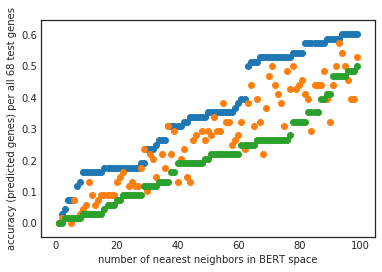

In [230]:
results, results_random, results_random_model = plot_distance_vs_accuracy()
plt.scatter(*results.T)
plt.scatter(*results_random.T)
plt.scatter(*results_random_model.T)
plt.xlabel('number of nearest neighbors in BERT space')
plt.ylabel('accuracy (predicted genes) per all 68 test genes')
print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


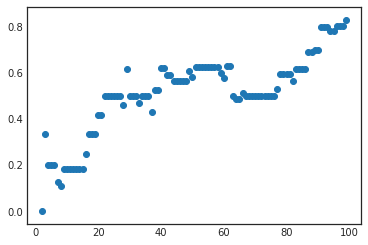

In [235]:
plt.scatter(results.T[0], (results_random_model.T[1] / results.T[1]))